In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

print(tf.__version__)

2.8.0


In [2]:
path = '../../../project_data/data/fer_data.csv'
df = pd.read_csv(path)

# creating a dataframe that only contains training data
train = df[df['usage']=='train'].copy()
# dropping the usage column
train.drop(['usage'], axis = 1, inplace = True)
train.reset_index(inplace = True, drop = True)

# creating a dataframe that only contains training data
test = df[df['usage']=='test'].copy()
# dropping the usage column
test.drop(['usage'], axis = 1, inplace = True)
test.reset_index(inplace = True, drop = True)

# shuffling the test set
test = test.sample(frac=1).reset_index(drop=True)

In [3]:
# defininng validation set's length as a half of the original test set
valid_len = int(len(test)/2)
# and test as the remaining haflf
test_len = int(len(test) - valid_len)
print(valid_len,test_len)

3948 3948


In [4]:
valid = test.iloc[:valid_len,:]
valid.reset_index(inplace = True, drop=True)

test = test.iloc[test_len:,:]
test.reset_index(inplace = True, drop=True)

test.shape, valid.shape

((3948, 2), (3948, 2))

In [5]:
test.emotion.value_counts(normalize=True)

3    0.227964
4    0.160081
6    0.151469
2    0.124367
0    0.121834
1    0.109169
5    0.105117
Name: emotion, dtype: float64

In [6]:
valid.emotion.value_counts(normalize=True)

3    0.221378
6    0.160841
4    0.155775
2    0.135005
0    0.120567
5    0.105370
1    0.101064
Name: emotion, dtype: float64

In [7]:
test.head()

,emotion,pixels
0,0,70 66 31 9 10 8 8 11 24 49 62 93 117 124 125 1...
1,6,113 100 99 91 95 132 167 184 177 181 184 169 1...
2,3,217 219 203 178 163 161 135 151 162 168 184 20...
3,4,161 163 144 150 167 157 169 184 182 180 192 19...
4,4,195 192 183 183 165 169 189 165 131 73 19 28 3...


In [8]:
valid.head()

,emotion,pixels
0,2,177 145 75 55 65 64 115 197 172 146 130 116 11...
1,4,12 11 10 33 37 52 63 60 69 60 60 64 62 50 37 3...
2,0,181 179 177 175 175 175 173 171 169 166 166 16...
3,4,250 250 248 250 248 249 249 250 251 146 49 45 ...
4,6,7 7 10 9 5 5 8 7 13 20 23 27 26 21 21 17 12 13...


In [9]:
def get_pixels_and_scale(data):
    '''
    Function for extracting pixel values from the pixel column and scaling them between 0 and 1
    
    get values from the column|
    split on the whitespace
    convert to float16 datatype
    save as as numpy array
    scale the values between 0 and 1
    '''
    
    img_array = np.array(data.split(' '), dtype = 'float16')
    img_array = img_array / 255.0
    
    return img_array

def reshape_images(data):
    '''
    reshape pixels column into a (48,48,1)format
    return a numpy array
    '''

    reshaped_array = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    
    return reshaped_array

In [10]:
train['pixels'] = train['pixels'].apply(get_pixels_and_scale)
test['pixels'] = test['pixels'].apply(get_pixels_and_scale)
valid['pixels'] = valid['pixels'].apply(get_pixels_and_scale)

In [11]:
X_train = reshape_images(train)
y_train = train['emotion'].to_numpy()

X_test = reshape_images(test)
y_test = test['emotion'].to_numpy()

X_valid = reshape_images(valid)
y_valid = valid['emotion'].to_numpy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(31432, 48, 48, 1) (31432,)
(3948, 48, 48, 1) (3948,)
(3948, 48, 48, 1) (3948,)


In [12]:
def plot_model_accuracy(fitted_model):
    '''
    Function visualizing comparison of 
    training and validaton loss and accuracy
    
    '''
    
    fig , ax = plt.subplots(1,2)
    train_acc = fitted_model.history['accuracy']
    train_loss = fitted_model.history['loss']
    fig.set_size_inches(15,4)

    ax[0].plot(fitted_model.history['accuracy'])
    ax[0].plot(fitted_model.history['val_accuracy'])
    ax[0].set_title('Training vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(fitted_model.history['loss'])
    ax[1].plot(fitted_model.history['val_loss'])
    ax[1].set_title('Training vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Training', 'Validation'], loc='lower left')

    plt.show()

## Final Model

In [13]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('../../../project_data/mdl16_2_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

# define number of epochs with no improvement after which training will be stopped
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=20,
                          mode='max')

#define callbacks
callbacks = [earlystop, checkpoint]

Metal device set to: Apple M1


2022-05-18 23:06:10.234934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-18 23:06:10.235021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-05-18 23:06:10.479779: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-18 23:06:10.904873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.0169 - accuracy: 0.2267

2022-05-18 23:06:22.414545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 13s 378ms/step - loss: 2.0169 - accuracy: 0.2267 - val_loss: 1.9596 - val_accuracy: 0.2214
Epoch 2/100
30/30 [==============================] - 12s 374ms/step - loss: 1.9168 - accuracy: 0.2291 - val_loss: 1.9024 - val_accuracy: 0.2214
Epoch 3/100
30/30 [==============================] - 11s 359ms/step - loss: 1.8987 - accuracy: 0.2290 - val_loss: 1.8896 - val_accuracy: 0.2221
Epoch 4/100
30/30 [==============================] - 11s 359ms/step - loss: 1.8940 - accuracy: 0.2310 - val_loss: 1.8907 - val_accuracy: 0.2247
Epoch 5/100
30/30 [==============================] - 11s 364ms/step - loss: 1.8884 - accuracy: 0.2317 - val_loss: 1.8806 - val_accuracy: 0.2277
Epoch 6/100
30/30 [==============================] - 11s 359ms/step - loss: 1.8819 - accuracy: 0.2353 - val_loss: 1.8791 - val_accuracy: 0.2366
Epoch 7/100
30/30 [==============================] - 11s 356ms/step - loss: 1.8741 - accuracy: 0.2419 - val_loss: 1.8464 - val_accuracy: 0.2573
Epoc

30/30 [==============================] - 12s 394ms/step - loss: 1.4243 - accuracy: 0.4613 - val_loss: 1.2784 - val_accuracy: 0.5215
Epoch 58/100
30/30 [==============================] - 12s 395ms/step - loss: 1.4166 - accuracy: 0.4678 - val_loss: 1.2690 - val_accuracy: 0.5350
Epoch 59/100
30/30 [==============================] - 12s 385ms/step - loss: 1.4111 - accuracy: 0.4733 - val_loss: 1.2278 - val_accuracy: 0.5461
Epoch 60/100
30/30 [==============================] - 12s 384ms/step - loss: 1.4180 - accuracy: 0.4678 - val_loss: 1.2206 - val_accuracy: 0.5484
Epoch 61/100
30/30 [==============================] - 12s 374ms/step - loss: 1.3965 - accuracy: 0.4749 - val_loss: 1.2487 - val_accuracy: 0.5375
Epoch 62/100
30/30 [==============================] - 12s 373ms/step - loss: 1.4103 - accuracy: 0.4693 - val_loss: 1.2304 - val_accuracy: 0.5486
Epoch 63/100
30/30 [==============================] - 12s 371ms/step - loss: 1.4023 - accuracy: 0.4745 - val_loss: 1.2694 - val_accuracy: 0.525

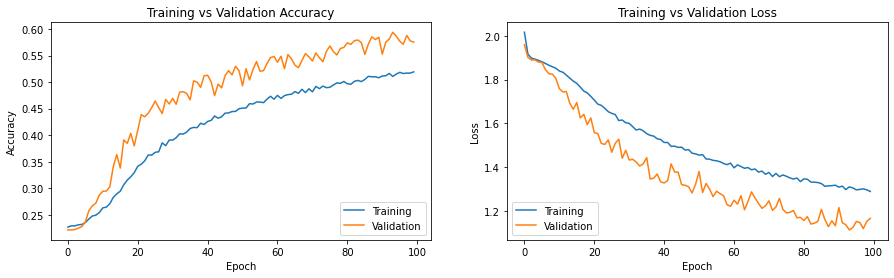

Evaluate on test data
 1/31 [..............................] - ETA: 6s - loss: 1.0464 - accuracy: 0.5938

2022-05-18 23:26:46.602590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 18ms/step - loss: 1.1488 - accuracy: 0.5737
test_loss, test_acc:  1.1488 57.3708


In [14]:
mdl16_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl16_2.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl16_2 = mdl16_2.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 100,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_2)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_2.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

# 2000 epochs - stopped by Early Stopping

In [15]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint('../../../project_data/mdl16_2_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

# define number of epochs with no improvement after which training will be stopped
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                          patience=20,
                          mode='max')

#define callbacks
callbacks = [earlystop, checkpoint]

Epoch 1/2000


2022-05-18 23:35:28.485124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 2.0175 - accuracy: 0.2263

2022-05-18 23:35:40.098948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 13s 385ms/step - loss: 2.0175 - accuracy: 0.2263 - val_loss: 1.9606 - val_accuracy: 0.2214
Epoch 2/2000
30/30 [==============================] - 12s 379ms/step - loss: 1.9162 - accuracy: 0.2290 - val_loss: 1.9023 - val_accuracy: 0.2249
Epoch 3/2000
30/30 [==============================] - 12s 378ms/step - loss: 1.9009 - accuracy: 0.2286 - val_loss: 1.9109 - val_accuracy: 0.2216
Epoch 4/2000
30/30 [==============================] - 12s 395ms/step - loss: 1.8949 - accuracy: 0.2303 - val_loss: 1.8855 - val_accuracy: 0.2244
Epoch 5/2000
30/30 [==============================] - 12s 382ms/step - loss: 1.8900 - accuracy: 0.2321 - val_loss: 1.8832 - val_accuracy: 0.2378
Epoch 6/2000
30/30 [==============================] - 12s 373ms/step - loss: 1.8845 - accuracy: 0.2340 - val_loss: 1.8661 - val_accuracy: 0.2538
Epoch 7/2000
30/30 [==============================] - 11s 362ms/step - loss: 1.8765 - accuracy: 0.2393 - val_loss: 1.8632 - val_accuracy: 0.241

30/30 [==============================] - 11s 360ms/step - loss: 1.4234 - accuracy: 0.4646 - val_loss: 1.3544 - val_accuracy: 0.4939
Epoch 58/2000
30/30 [==============================] - 11s 361ms/step - loss: 1.4258 - accuracy: 0.4621 - val_loss: 1.3180 - val_accuracy: 0.5096
Epoch 59/2000
30/30 [==============================] - 11s 360ms/step - loss: 1.4166 - accuracy: 0.4695 - val_loss: 1.2653 - val_accuracy: 0.5299
Epoch 60/2000
30/30 [==============================] - 11s 357ms/step - loss: 1.4149 - accuracy: 0.4710 - val_loss: 1.2621 - val_accuracy: 0.5256
Epoch 61/2000
30/30 [==============================] - 11s 359ms/step - loss: 1.4074 - accuracy: 0.4707 - val_loss: 1.2498 - val_accuracy: 0.5337
Epoch 62/2000
30/30 [==============================] - 11s 363ms/step - loss: 1.4102 - accuracy: 0.4693 - val_loss: 1.2243 - val_accuracy: 0.5504
Epoch 63/2000
30/30 [==============================] - 11s 359ms/step - loss: 1.4066 - accuracy: 0.4714 - val_loss: 1.2552 - val_accuracy:

30/30 [==============================] - 11s 358ms/step - loss: 1.2683 - accuracy: 0.5283 - val_loss: 1.0831 - val_accuracy: 0.6031
Epoch 114/2000
30/30 [==============================] - 11s 356ms/step - loss: 1.2567 - accuracy: 0.5320 - val_loss: 1.0843 - val_accuracy: 0.6059
Epoch 115/2000
30/30 [==============================] - 11s 363ms/step - loss: 1.2666 - accuracy: 0.5286 - val_loss: 1.0967 - val_accuracy: 0.5985
Epoch 116/2000
30/30 [==============================] - 11s 359ms/step - loss: 1.2657 - accuracy: 0.5290 - val_loss: 1.0930 - val_accuracy: 0.5945
Epoch 117/2000
30/30 [==============================] - 11s 358ms/step - loss: 1.2545 - accuracy: 0.5347 - val_loss: 1.1218 - val_accuracy: 0.5846
Epoch 118/2000
30/30 [==============================] - 11s 357ms/step - loss: 1.2523 - accuracy: 0.5343 - val_loss: 1.0906 - val_accuracy: 0.5945
Epoch 119/2000
30/30 [==============================] - 11s 361ms/step - loss: 1.2531 - accuracy: 0.5327 - val_loss: 1.0949 - val_acc

Epoch 169/2000
30/30 [==============================] - 11s 360ms/step - loss: 1.1812 - accuracy: 0.5632 - val_loss: 1.0337 - val_accuracy: 0.6228
Epoch 170/2000
30/30 [==============================] - 11s 358ms/step - loss: 1.1837 - accuracy: 0.5606 - val_loss: 1.0376 - val_accuracy: 0.6221
Epoch 171/2000
30/30 [==============================] - 11s 363ms/step - loss: 1.1881 - accuracy: 0.5581 - val_loss: 1.0525 - val_accuracy: 0.6165
Epoch 172/2000
30/30 [==============================] - 921s 31s/step - loss: 1.1766 - accuracy: 0.5621 - val_loss: 1.0779 - val_accuracy: 0.6046
Epoch 173/2000
30/30 [==============================] - 12s 372ms/step - loss: 1.1820 - accuracy: 0.5582 - val_loss: 1.0396 - val_accuracy: 0.6173
Epoch 174/2000
30/30 [==============================] - 11s 358ms/step - loss: 1.1788 - accuracy: 0.5633 - val_loss: 1.0263 - val_accuracy: 0.6317
Epoch 175/2000
30/30 [==============================] - 11s 355ms/step - loss: 1.1796 - accuracy: 0.5626 - val_loss: 1.

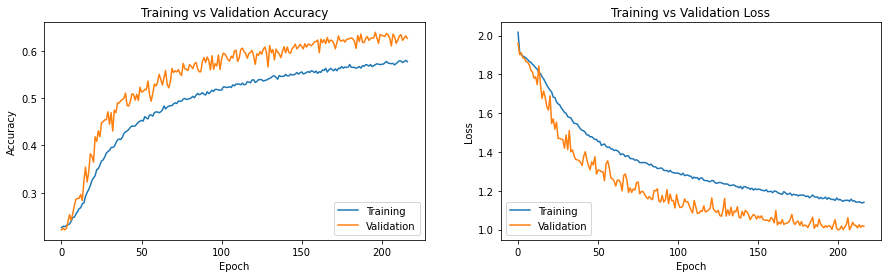

Evaluate on test data
 1/31 [..............................] - ETA: 8s - loss: 0.8801 - accuracy: 0.6719

2022-05-19 02:45:28.716734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 18ms/step - loss: 1.0078 - accuracy: 0.6315
test_loss, test_acc:  1.0078 63.1459


In [16]:
mdl16_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3), 
                           activation='relu', 
                           input_shape=(48, 48, 1),
                           padding='same',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu',
                           activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu',
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(7, activation='softmax',
                          activity_regularizer=regularizers.L2(1e-3))
])

mdl16_3.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0005),
              metrics=['accuracy'])

history_mdl16_3 = mdl16_3.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 2000,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_3)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_3.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

In [17]:
mdl16_3.save('../../../project_data/mdl16_3.h5')

# 16.4 - continuing without early stopping

In [18]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint_path = "../../../project_data/train_ckpt/cp.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                save_weights_only=True,
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

#define callbacks
callbacks = [checkpoint]

In [20]:
# load the model and run a summary
mdl16_4 = tf.keras.models.load_model('../../../project_data/mdl16_3.h5')
mdl16_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

Epoch 1/1000


2022-05-19 07:42:16.167361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 1.1480 - accuracy: 0.5747

2022-05-19 07:42:28.892871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.62893, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 14s 402ms/step - loss: 1.1480 - accuracy: 0.5747 - val_loss: 0.9995 - val_accuracy: 0.6289
Epoch 2/1000
31/30 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.5747
Epoch 2: val_accuracy improved from 0.62893 to 0.64438, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 11s 358ms/step - loss: 1.1522 - accuracy: 0.5747 - val_loss: 0.9891 - val_accuracy: 0.6444
Epoch 3/1000
31/30 [==============================] - ETA: 0s - loss: 1.1476 - accuracy: 0.5767
Epoch 3: val_accuracy did not improve from 0.64438
30/30 [==============================] - 11s 355ms/step - loss: 1.1476 - accuracy: 0.5767 - val_loss: 1.0152 - val_accuracy: 0.6292
Epoch 4/1000
31/30 [==============================] - ETA: 0s - loss: 1.1491 - accuracy: 0.5735
Epoch 4: val_accuracy did not improve fro

30/30 [==============================] - 11s 364ms/step - loss: 1.1369 - accuracy: 0.5802 - val_loss: 0.9775 - val_accuracy: 0.6464
Epoch 30/1000
31/30 [==============================] - ETA: 0s - loss: 1.1235 - accuracy: 0.5843
Epoch 30: val_accuracy did not improve from 0.64919
30/30 [==============================] - 12s 382ms/step - loss: 1.1235 - accuracy: 0.5843 - val_loss: 1.0027 - val_accuracy: 0.6332
Epoch 31/1000
31/30 [==============================] - ETA: 0s - loss: 1.1372 - accuracy: 0.5775
Epoch 31: val_accuracy did not improve from 0.64919
30/30 [==============================] - 12s 372ms/step - loss: 1.1372 - accuracy: 0.5775 - val_loss: 0.9795 - val_accuracy: 0.6348
Epoch 32/1000
31/30 [==============================] - ETA: 0s - loss: 1.1257 - accuracy: 0.5847
Epoch 32: val_accuracy did not improve from 0.64919
30/30 [==============================] - 12s 374ms/step - loss: 1.1257 - accuracy: 0.5847 - val_loss: 1.0167 - val_accuracy: 0.6264
Epoch 33/1000
31/30 [====

31/30 [==============================] - ETA: 0s - loss: 1.1103 - accuracy: 0.5879
Epoch 58: val_accuracy did not improve from 0.65426
30/30 [==============================] - 12s 382ms/step - loss: 1.1103 - accuracy: 0.5879 - val_loss: 0.9690 - val_accuracy: 0.6456
Epoch 59/1000
31/30 [==============================] - ETA: 0s - loss: 1.1150 - accuracy: 0.5890
Epoch 59: val_accuracy did not improve from 0.65426
30/30 [==============================] - 13s 413ms/step - loss: 1.1150 - accuracy: 0.5890 - val_loss: 0.9758 - val_accuracy: 0.6408
Epoch 60/1000
31/30 [==============================] - ETA: 0s - loss: 1.1064 - accuracy: 0.5899
Epoch 60: val_accuracy did not improve from 0.65426
30/30 [==============================] - 12s 395ms/step - loss: 1.1064 - accuracy: 0.5899 - val_loss: 0.9753 - val_accuracy: 0.6418
Epoch 61/1000
31/30 [==============================] - ETA: 0s - loss: 1.1099 - accuracy: 0.5904
Epoch 61: val_accuracy did not improve from 0.65426
30/30 [===============

31/30 [==============================] - ETA: 0s - loss: 1.0962 - accuracy: 0.5948
Epoch 87: val_accuracy did not improve from 0.65426
30/30 [==============================] - 15s 491ms/step - loss: 1.0962 - accuracy: 0.5948 - val_loss: 0.9737 - val_accuracy: 0.6456
Epoch 88/1000
31/30 [==============================] - ETA: 0s - loss: 1.0955 - accuracy: 0.5927
Epoch 88: val_accuracy did not improve from 0.65426
30/30 [==============================] - 15s 472ms/step - loss: 1.0955 - accuracy: 0.5927 - val_loss: 0.9781 - val_accuracy: 0.6472
Epoch 89/1000
31/30 [==============================] - ETA: 0s - loss: 1.0914 - accuracy: 0.5984
Epoch 89: val_accuracy did not improve from 0.65426
30/30 [==============================] - 15s 481ms/step - loss: 1.0914 - accuracy: 0.5984 - val_loss: 0.9525 - val_accuracy: 0.6510
Epoch 90/1000
31/30 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.5939
Epoch 90: val_accuracy did not improve from 0.65426
30/30 [===============

Epoch 116/1000
31/30 [==============================] - ETA: 0s - loss: 1.0776 - accuracy: 0.6016
Epoch 116: val_accuracy did not improve from 0.66109
30/30 [==============================] - 16s 525ms/step - loss: 1.0776 - accuracy: 0.6016 - val_loss: 0.9491 - val_accuracy: 0.6588
Epoch 117/1000
31/30 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.6009
Epoch 117: val_accuracy did not improve from 0.66109
30/30 [==============================] - 16s 522ms/step - loss: 1.0777 - accuracy: 0.6009 - val_loss: 0.9459 - val_accuracy: 0.6512
Epoch 118/1000
31/30 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.5991
Epoch 118: val_accuracy did not improve from 0.66109
30/30 [==============================] - 17s 541ms/step - loss: 1.0874 - accuracy: 0.5991 - val_loss: 0.9455 - val_accuracy: 0.6606
Epoch 119/1000
31/30 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.5999
Epoch 119: val_accuracy did not improve from 0.66109


30/30 [==============================] - 17s 553ms/step - loss: 1.0746 - accuracy: 0.6050 - val_loss: 0.9244 - val_accuracy: 0.6591
Epoch 145/1000
31/30 [==============================] - ETA: 0s - loss: 1.0743 - accuracy: 0.6046
Epoch 145: val_accuracy did not improve from 0.66337
30/30 [==============================] - 17s 545ms/step - loss: 1.0743 - accuracy: 0.6046 - val_loss: 0.9630 - val_accuracy: 0.6464
Epoch 146/1000
31/30 [==============================] - ETA: 0s - loss: 1.0725 - accuracy: 0.6033
Epoch 146: val_accuracy did not improve from 0.66337
30/30 [==============================] - 17s 563ms/step - loss: 1.0725 - accuracy: 0.6033 - val_loss: 0.9400 - val_accuracy: 0.6631
Epoch 147/1000
31/30 [==============================] - ETA: 0s - loss: 1.0650 - accuracy: 0.6073
Epoch 147: val_accuracy did not improve from 0.66337
30/30 [==============================] - 18s 565ms/step - loss: 1.0650 - accuracy: 0.6073 - val_loss: 0.9541 - val_accuracy: 0.6502
Epoch 148/1000
31/3

31/30 [==============================] - ETA: 0s - loss: 1.0639 - accuracy: 0.6087
Epoch 173: val_accuracy did not improve from 0.66591
30/30 [==============================] - 17s 536ms/step - loss: 1.0639 - accuracy: 0.6087 - val_loss: 0.9185 - val_accuracy: 0.6659
Epoch 174/1000
31/30 [==============================] - ETA: 0s - loss: 1.0649 - accuracy: 0.6060
Epoch 174: val_accuracy did not improve from 0.66591
30/30 [==============================] - 17s 544ms/step - loss: 1.0649 - accuracy: 0.6060 - val_loss: 0.9650 - val_accuracy: 0.6418
Epoch 175/1000
31/30 [==============================] - ETA: 0s - loss: 1.0612 - accuracy: 0.6081
Epoch 175: val_accuracy did not improve from 0.66591
30/30 [==============================] - 17s 540ms/step - loss: 1.0612 - accuracy: 0.6081 - val_loss: 0.9482 - val_accuracy: 0.6560
Epoch 176/1000
31/30 [==============================] - ETA: 0s - loss: 1.0615 - accuracy: 0.6073
Epoch 176: val_accuracy did not improve from 0.66591
30/30 [========

Epoch 202/1000
31/30 [==============================] - ETA: 0s - loss: 1.0487 - accuracy: 0.6137
Epoch 202: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 563ms/step - loss: 1.0487 - accuracy: 0.6137 - val_loss: 0.9262 - val_accuracy: 0.6593
Epoch 203/1000
31/30 [==============================] - ETA: 0s - loss: 1.0494 - accuracy: 0.6142
Epoch 203: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 556ms/step - loss: 1.0494 - accuracy: 0.6142 - val_loss: 0.9393 - val_accuracy: 0.6530
Epoch 204/1000
31/30 [==============================] - ETA: 0s - loss: 1.0479 - accuracy: 0.6117
Epoch 204: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 561ms/step - loss: 1.0479 - accuracy: 0.6117 - val_loss: 0.9471 - val_accuracy: 0.6494
Epoch 205/1000
31/30 [==============================] - ETA: 0s - loss: 1.0528 - accuracy: 0.6116
Epoch 205: val_accuracy did not improve from 0.66667


Epoch 231/1000
31/30 [==============================] - ETA: 0s - loss: 1.0431 - accuracy: 0.6114
Epoch 231: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 557ms/step - loss: 1.0431 - accuracy: 0.6114 - val_loss: 0.9355 - val_accuracy: 0.6570
Epoch 232/1000
31/30 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.6077
Epoch 232: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 555ms/step - loss: 1.0525 - accuracy: 0.6077 - val_loss: 0.9162 - val_accuracy: 0.6613
Epoch 233/1000
31/30 [==============================] - ETA: 0s - loss: 1.0392 - accuracy: 0.6182
Epoch 233: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 550ms/step - loss: 1.0392 - accuracy: 0.6182 - val_loss: 0.9468 - val_accuracy: 0.6525
Epoch 234/1000
31/30 [==============================] - ETA: 0s - loss: 1.0490 - accuracy: 0.6125
Epoch 234: val_accuracy did not improve from 0.66667


Epoch 260/1000
31/30 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.6153
Epoch 260: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 547ms/step - loss: 1.0457 - accuracy: 0.6153 - val_loss: 0.9595 - val_accuracy: 0.6479
Epoch 261/1000
31/30 [==============================] - ETA: 0s - loss: 1.0377 - accuracy: 0.6155
Epoch 261: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 552ms/step - loss: 1.0377 - accuracy: 0.6155 - val_loss: 0.9238 - val_accuracy: 0.6573
Epoch 262/1000
31/30 [==============================] - ETA: 0s - loss: 1.0326 - accuracy: 0.6167
Epoch 262: val_accuracy did not improve from 0.66667
30/30 [==============================] - 18s 566ms/step - loss: 1.0326 - accuracy: 0.6167 - val_loss: 0.9307 - val_accuracy: 0.6563
Epoch 263/1000
31/30 [==============================] - ETA: 0s - loss: 1.0373 - accuracy: 0.6161
Epoch 263: val_accuracy did not improve from 0.66667


Epoch 289/1000
31/30 [==============================] - ETA: 0s - loss: 1.0363 - accuracy: 0.6198
Epoch 289: val_accuracy did not improve from 0.66667
30/30 [==============================] - 17s 540ms/step - loss: 1.0363 - accuracy: 0.6198 - val_loss: 0.9397 - val_accuracy: 0.6619
Epoch 290/1000
31/30 [==============================] - ETA: 0s - loss: 1.0274 - accuracy: 0.6196
Epoch 290: val_accuracy improved from 0.66667 to 0.66743, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 17s 544ms/step - loss: 1.0274 - accuracy: 0.6196 - val_loss: 0.9109 - val_accuracy: 0.6674
Epoch 291/1000
31/30 [==============================] - ETA: 0s - loss: 1.0291 - accuracy: 0.6200
Epoch 291: val_accuracy improved from 0.66743 to 0.66996, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 17s 544ms/step - loss: 1.0291 - accuracy: 0.6200 - val_loss: 0.9178 - val_accuracy: 0.6700
Epoch 292/1000
31/30 [=====

30/30 [==============================] - 17s 555ms/step - loss: 1.0190 - accuracy: 0.6239 - val_loss: 0.9189 - val_accuracy: 0.6624
Epoch 318/1000
31/30 [==============================] - ETA: 0s - loss: 1.0239 - accuracy: 0.6206
Epoch 318: val_accuracy did not improve from 0.66996
30/30 [==============================] - 17s 546ms/step - loss: 1.0239 - accuracy: 0.6206 - val_loss: 0.9330 - val_accuracy: 0.6532
Epoch 319/1000
31/30 [==============================] - ETA: 0s - loss: 1.0182 - accuracy: 0.6231
Epoch 319: val_accuracy did not improve from 0.66996
30/30 [==============================] - 17s 559ms/step - loss: 1.0182 - accuracy: 0.6231 - val_loss: 0.9261 - val_accuracy: 0.6608
Epoch 320/1000
31/30 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.6189
Epoch 320: val_accuracy did not improve from 0.66996
30/30 [==============================] - 17s 545ms/step - loss: 1.0242 - accuracy: 0.6189 - val_loss: 0.9261 - val_accuracy: 0.6578
Epoch 321/1000
31/3

Epoch 346/1000
31/30 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.6256
Epoch 346: val_accuracy did not improve from 0.67477
30/30 [==============================] - 17s 552ms/step - loss: 1.0144 - accuracy: 0.6256 - val_loss: 0.8966 - val_accuracy: 0.6717
Epoch 347/1000
31/30 [==============================] - ETA: 0s - loss: 1.0189 - accuracy: 0.6255
Epoch 347: val_accuracy did not improve from 0.67477
30/30 [==============================] - 17s 549ms/step - loss: 1.0189 - accuracy: 0.6255 - val_loss: 0.9211 - val_accuracy: 0.6624
Epoch 348/1000
31/30 [==============================] - ETA: 0s - loss: 1.0190 - accuracy: 0.6240
Epoch 348: val_accuracy did not improve from 0.67477
30/30 [==============================] - 17s 542ms/step - loss: 1.0190 - accuracy: 0.6240 - val_loss: 0.9158 - val_accuracy: 0.6636
Epoch 349/1000
31/30 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.6261
Epoch 349: val_accuracy did not improve from 0.67477


Epoch 375/1000
31/30 [==============================] - ETA: 0s - loss: 1.0118 - accuracy: 0.6247
Epoch 375: val_accuracy did not improve from 0.67477
30/30 [==============================] - 17s 535ms/step - loss: 1.0118 - accuracy: 0.6247 - val_loss: 0.9403 - val_accuracy: 0.6639
Epoch 376/1000
31/30 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.6276
Epoch 376: val_accuracy did not improve from 0.67477
30/30 [==============================] - 17s 537ms/step - loss: 1.0104 - accuracy: 0.6276 - val_loss: 0.9273 - val_accuracy: 0.6646
Epoch 377/1000
31/30 [==============================] - ETA: 0s - loss: 1.0079 - accuracy: 0.6261
Epoch 377: val_accuracy did not improve from 0.67477
30/30 [==============================] - 17s 547ms/step - loss: 1.0079 - accuracy: 0.6261 - val_loss: 0.9019 - val_accuracy: 0.6745
Epoch 378/1000
31/30 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.6288
Epoch 378: val_accuracy did not improve from 0.67477


Epoch 404/1000
31/30 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.6270
Epoch 404: val_accuracy improved from 0.67477 to 0.67553, saving model to ../../../project_data/train_ckpt/cp.ckpt
30/30 [==============================] - 17s 543ms/step - loss: 1.0154 - accuracy: 0.6270 - val_loss: 0.9002 - val_accuracy: 0.6755
Epoch 405/1000
31/30 [==============================] - ETA: 0s - loss: 1.0028 - accuracy: 0.6277
Epoch 405: val_accuracy did not improve from 0.67553
30/30 [==============================] - 16s 530ms/step - loss: 1.0028 - accuracy: 0.6277 - val_loss: 0.9107 - val_accuracy: 0.6720
Epoch 406/1000
31/30 [==============================] - ETA: 0s - loss: 1.0073 - accuracy: 0.6291
Epoch 406: val_accuracy did not improve from 0.67553
30/30 [==============================] - 17s 536ms/step - loss: 1.0073 - accuracy: 0.6291 - val_loss: 0.9204 - val_accuracy: 0.6700
Epoch 407/1000
31/30 [==============================] - ETA: 0s - loss: 1.0057 - accuracy

31/30 [==============================] - ETA: 0s - loss: 0.9980 - accuracy: 0.6331
Epoch 432: val_accuracy did not improve from 0.67908
30/30 [==============================] - 16s 534ms/step - loss: 0.9980 - accuracy: 0.6331 - val_loss: 0.9178 - val_accuracy: 0.6662
Epoch 433/1000
31/30 [==============================] - ETA: 0s - loss: 1.0026 - accuracy: 0.6307
Epoch 433: val_accuracy did not improve from 0.67908
30/30 [==============================] - 16s 532ms/step - loss: 1.0026 - accuracy: 0.6307 - val_loss: 0.9002 - val_accuracy: 0.6679
Epoch 434/1000
31/30 [==============================] - ETA: 0s - loss: 1.0032 - accuracy: 0.6271
Epoch 434: val_accuracy did not improve from 0.67908
30/30 [==============================] - 17s 535ms/step - loss: 1.0032 - accuracy: 0.6271 - val_loss: 0.9342 - val_accuracy: 0.6624
Epoch 435/1000
31/30 [==============================] - ETA: 0s - loss: 1.0030 - accuracy: 0.6304
Epoch 435: val_accuracy did not improve from 0.67908
30/30 [========

31/30 [==============================] - ETA: 0s - loss: 1.0046 - accuracy: 0.6298
Epoch 461: val_accuracy did not improve from 0.67908
30/30 [==============================] - 16s 528ms/step - loss: 1.0046 - accuracy: 0.6298 - val_loss: 0.9102 - val_accuracy: 0.6692
Epoch 462/1000
31/30 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.6307
Epoch 462: val_accuracy did not improve from 0.67908
30/30 [==============================] - 16s 533ms/step - loss: 0.9963 - accuracy: 0.6307 - val_loss: 0.9026 - val_accuracy: 0.6717
Epoch 463/1000
31/30 [==============================] - ETA: 0s - loss: 0.9978 - accuracy: 0.6309
Epoch 463: val_accuracy did not improve from 0.67908
30/30 [==============================] - 16s 529ms/step - loss: 0.9978 - accuracy: 0.6309 - val_loss: 0.9174 - val_accuracy: 0.6710
Epoch 464/1000
31/30 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.6308
Epoch 464: val_accuracy did not improve from 0.67908
30/30 [========

Epoch 490/1000
31/30 [==============================] - ETA: 0s - loss: 0.9954 - accuracy: 0.6322
Epoch 490: val_accuracy did not improve from 0.68060
30/30 [==============================] - 17s 539ms/step - loss: 0.9954 - accuracy: 0.6322 - val_loss: 0.9167 - val_accuracy: 0.6641
Epoch 491/1000
31/30 [==============================] - ETA: 0s - loss: 0.9950 - accuracy: 0.6325
Epoch 491: val_accuracy did not improve from 0.68060
30/30 [==============================] - 17s 538ms/step - loss: 0.9950 - accuracy: 0.6325 - val_loss: 0.9362 - val_accuracy: 0.6563
Epoch 492/1000
31/30 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.6282
Epoch 492: val_accuracy did not improve from 0.68060
30/30 [==============================] - 16s 533ms/step - loss: 1.0053 - accuracy: 0.6282 - val_loss: 0.9179 - val_accuracy: 0.6626
Epoch 493/1000
31/30 [==============================] - ETA: 0s - loss: 0.9952 - accuracy: 0.6350
Epoch 493: val_accuracy did not improve from 0.68060


Epoch 519/1000
31/30 [==============================] - ETA: 0s - loss: 0.9902 - accuracy: 0.6315
Epoch 519: val_accuracy did not improve from 0.68212
30/30 [==============================] - 16s 522ms/step - loss: 0.9902 - accuracy: 0.6315 - val_loss: 0.9012 - val_accuracy: 0.6705
Epoch 520/1000
31/30 [==============================] - ETA: 0s - loss: 0.9891 - accuracy: 0.6342
Epoch 520: val_accuracy did not improve from 0.68212
30/30 [==============================] - 16s 520ms/step - loss: 0.9891 - accuracy: 0.6342 - val_loss: 0.9345 - val_accuracy: 0.6568
Epoch 521/1000
31/30 [==============================] - ETA: 0s - loss: 0.9885 - accuracy: 0.6364
Epoch 521: val_accuracy did not improve from 0.68212
30/30 [==============================] - 16s 518ms/step - loss: 0.9885 - accuracy: 0.6364 - val_loss: 0.9075 - val_accuracy: 0.6695
Epoch 522/1000
31/30 [==============================] - ETA: 0s - loss: 0.9974 - accuracy: 0.6332
Epoch 522: val_accuracy did not improve from 0.68212


Epoch 548/1000
31/30 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.6326
Epoch 548: val_accuracy did not improve from 0.68212
30/30 [==============================] - 16s 508ms/step - loss: 0.9898 - accuracy: 0.6326 - val_loss: 0.8932 - val_accuracy: 0.6733
Epoch 549/1000
31/30 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.6354
Epoch 549: val_accuracy did not improve from 0.68212
30/30 [==============================] - 16s 509ms/step - loss: 0.9904 - accuracy: 0.6354 - val_loss: 0.8995 - val_accuracy: 0.6669
Epoch 550/1000
31/30 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.6358
Epoch 550: val_accuracy did not improve from 0.68212
30/30 [==============================] - 16s 508ms/step - loss: 0.9877 - accuracy: 0.6358 - val_loss: 0.8999 - val_accuracy: 0.6717
Epoch 551/1000
31/30 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6368
Epoch 551: val_accuracy did not improve from 0.68212


Epoch 577/1000
31/30 [==============================] - ETA: 0s - loss: 0.9865 - accuracy: 0.6377
Epoch 577: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 487ms/step - loss: 0.9865 - accuracy: 0.6377 - val_loss: 0.9230 - val_accuracy: 0.6621
Epoch 578/1000
31/30 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.6380
Epoch 578: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 486ms/step - loss: 0.9818 - accuracy: 0.6380 - val_loss: 0.9081 - val_accuracy: 0.6722
Epoch 579/1000
31/30 [==============================] - ETA: 0s - loss: 0.9812 - accuracy: 0.6371
Epoch 579: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 484ms/step - loss: 0.9812 - accuracy: 0.6371 - val_loss: 0.9195 - val_accuracy: 0.6679
Epoch 580/1000
31/30 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.6365
Epoch 580: val_accuracy did not improve from 0.68212


Epoch 606/1000
31/30 [==============================] - ETA: 0s - loss: 0.9828 - accuracy: 0.6371
Epoch 606: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 483ms/step - loss: 0.9828 - accuracy: 0.6371 - val_loss: 0.9053 - val_accuracy: 0.6743
Epoch 607/1000
31/30 [==============================] - ETA: 0s - loss: 0.9905 - accuracy: 0.6342
Epoch 607: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 483ms/step - loss: 0.9905 - accuracy: 0.6342 - val_loss: 0.8975 - val_accuracy: 0.6687
Epoch 608/1000
31/30 [==============================] - ETA: 0s - loss: 0.9823 - accuracy: 0.6415
Epoch 608: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 489ms/step - loss: 0.9823 - accuracy: 0.6415 - val_loss: 0.9040 - val_accuracy: 0.6684
Epoch 609/1000
31/30 [==============================] - ETA: 0s - loss: 0.9778 - accuracy: 0.6400
Epoch 609: val_accuracy did not improve from 0.68212


Epoch 635/1000
31/30 [==============================] - ETA: 0s - loss: 0.9752 - accuracy: 0.6389
Epoch 635: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 478ms/step - loss: 0.9752 - accuracy: 0.6389 - val_loss: 0.8987 - val_accuracy: 0.6735
Epoch 636/1000
31/30 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.6404
Epoch 636: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 480ms/step - loss: 0.9799 - accuracy: 0.6404 - val_loss: 0.8976 - val_accuracy: 0.6702
Epoch 637/1000
31/30 [==============================] - ETA: 0s - loss: 0.9807 - accuracy: 0.6371
Epoch 637: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 485ms/step - loss: 0.9807 - accuracy: 0.6371 - val_loss: 0.8970 - val_accuracy: 0.6740
Epoch 638/1000
31/30 [==============================] - ETA: 0s - loss: 0.9738 - accuracy: 0.6411
Epoch 638: val_accuracy did not improve from 0.68212


Epoch 664/1000
31/30 [==============================] - ETA: 0s - loss: 0.9748 - accuracy: 0.6399
Epoch 664: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 479ms/step - loss: 0.9748 - accuracy: 0.6399 - val_loss: 0.8959 - val_accuracy: 0.6735
Epoch 665/1000
31/30 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.6449
Epoch 665: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 478ms/step - loss: 0.9701 - accuracy: 0.6449 - val_loss: 0.8905 - val_accuracy: 0.6740
Epoch 666/1000
31/30 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.6398
Epoch 666: val_accuracy did not improve from 0.68212
30/30 [==============================] - 15s 482ms/step - loss: 0.9759 - accuracy: 0.6398 - val_loss: 0.9001 - val_accuracy: 0.6692
Epoch 667/1000
31/30 [==============================] - ETA: 0s - loss: 0.9800 - accuracy: 0.6392
Epoch 667: val_accuracy did not improve from 0.68212


Epoch 693/1000
31/30 [==============================] - ETA: 0s - loss: 0.9641 - accuracy: 0.6459
Epoch 693: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 471ms/step - loss: 0.9641 - accuracy: 0.6459 - val_loss: 0.9017 - val_accuracy: 0.6735
Epoch 694/1000
31/30 [==============================] - ETA: 0s - loss: 0.9736 - accuracy: 0.6426
Epoch 694: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 471ms/step - loss: 0.9736 - accuracy: 0.6426 - val_loss: 0.9140 - val_accuracy: 0.6738
Epoch 695/1000
31/30 [==============================] - ETA: 0s - loss: 0.9767 - accuracy: 0.6404
Epoch 695: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 469ms/step - loss: 0.9767 - accuracy: 0.6404 - val_loss: 0.8845 - val_accuracy: 0.6809
Epoch 696/1000
31/30 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6408
Epoch 696: val_accuracy did not improve from 0.68313


Epoch 722/1000
31/30 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.6400
Epoch 722: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 472ms/step - loss: 0.9733 - accuracy: 0.6400 - val_loss: 0.8873 - val_accuracy: 0.6781
Epoch 723/1000
31/30 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.6474
Epoch 723: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 474ms/step - loss: 0.9652 - accuracy: 0.6474 - val_loss: 0.8941 - val_accuracy: 0.6763
Epoch 724/1000
31/30 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.6413
Epoch 724: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 472ms/step - loss: 0.9766 - accuracy: 0.6413 - val_loss: 0.9041 - val_accuracy: 0.6667
Epoch 725/1000
31/30 [==============================] - ETA: 0s - loss: 0.9683 - accuracy: 0.6417
Epoch 725: val_accuracy did not improve from 0.68313


Epoch 751/1000
31/30 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.6419
Epoch 751: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 483ms/step - loss: 0.9721 - accuracy: 0.6419 - val_loss: 0.9059 - val_accuracy: 0.6674
Epoch 752/1000
31/30 [==============================] - ETA: 0s - loss: 0.9593 - accuracy: 0.6461
Epoch 752: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 483ms/step - loss: 0.9593 - accuracy: 0.6461 - val_loss: 0.8890 - val_accuracy: 0.6791
Epoch 753/1000
31/30 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.6418
Epoch 753: val_accuracy did not improve from 0.68313
30/30 [==============================] - 15s 480ms/step - loss: 0.9718 - accuracy: 0.6418 - val_loss: 0.9219 - val_accuracy: 0.6646
Epoch 754/1000
31/30 [==============================] - ETA: 0s - loss: 0.9646 - accuracy: 0.6459
Epoch 754: val_accuracy did not improve from 0.68313


Epoch 780/1000
31/30 [==============================] - ETA: 0s - loss: 0.9719 - accuracy: 0.6436
Epoch 780: val_accuracy did not improve from 0.68668
30/30 [==============================] - 15s 483ms/step - loss: 0.9719 - accuracy: 0.6436 - val_loss: 0.9027 - val_accuracy: 0.6765
Epoch 781/1000
31/30 [==============================] - ETA: 0s - loss: 0.9695 - accuracy: 0.6456
Epoch 781: val_accuracy did not improve from 0.68668
30/30 [==============================] - 15s 485ms/step - loss: 0.9695 - accuracy: 0.6456 - val_loss: 0.8959 - val_accuracy: 0.6816
Epoch 782/1000
31/30 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.6457
Epoch 782: val_accuracy did not improve from 0.68668
30/30 [==============================] - 15s 487ms/step - loss: 0.9678 - accuracy: 0.6457 - val_loss: 0.8828 - val_accuracy: 0.6811
Epoch 783/1000
31/30 [==============================] - ETA: 0s - loss: 0.9616 - accuracy: 0.6448
Epoch 783: val_accuracy did not improve from 0.68668


Epoch 809/1000
31/30 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.6448
Epoch 809: val_accuracy did not improve from 0.68718
30/30 [==============================] - 15s 495ms/step - loss: 0.9629 - accuracy: 0.6448 - val_loss: 0.8914 - val_accuracy: 0.6786
Epoch 810/1000
31/30 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.6408
Epoch 810: val_accuracy did not improve from 0.68718
30/30 [==============================] - 15s 495ms/step - loss: 0.9733 - accuracy: 0.6408 - val_loss: 0.9000 - val_accuracy: 0.6821
Epoch 811/1000
31/30 [==============================] - ETA: 0s - loss: 0.9708 - accuracy: 0.6440
Epoch 811: val_accuracy did not improve from 0.68718
30/30 [==============================] - 16s 503ms/step - loss: 0.9708 - accuracy: 0.6440 - val_loss: 0.9020 - val_accuracy: 0.6725
Epoch 812/1000
31/30 [==============================] - ETA: 0s - loss: 0.9673 - accuracy: 0.6431
Epoch 812: val_accuracy did not improve from 0.68718


Epoch 838/1000
31/30 [==============================] - ETA: 0s - loss: 0.9656 - accuracy: 0.6457
Epoch 838: val_accuracy did not improve from 0.68718
30/30 [==============================] - 18s 577ms/step - loss: 0.9656 - accuracy: 0.6457 - val_loss: 0.8908 - val_accuracy: 0.6778
Epoch 839/1000
31/30 [==============================] - ETA: 0s - loss: 0.9584 - accuracy: 0.6452
Epoch 839: val_accuracy did not improve from 0.68718
30/30 [==============================] - 17s 548ms/step - loss: 0.9584 - accuracy: 0.6452 - val_loss: 0.8982 - val_accuracy: 0.6710
Epoch 840/1000
31/30 [==============================] - ETA: 0s - loss: 0.9658 - accuracy: 0.6429
Epoch 840: val_accuracy did not improve from 0.68718
30/30 [==============================] - 17s 556ms/step - loss: 0.9658 - accuracy: 0.6429 - val_loss: 0.8882 - val_accuracy: 0.6834
Epoch 841/1000
31/30 [==============================] - ETA: 0s - loss: 0.9619 - accuracy: 0.6444
Epoch 841: val_accuracy improved from 0.68718 to 0.69

Epoch 867/1000
31/30 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.6446
Epoch 867: val_accuracy did not improve from 0.69022
30/30 [==============================] - 17s 565ms/step - loss: 0.9604 - accuracy: 0.6446 - val_loss: 0.8918 - val_accuracy: 0.6745
Epoch 868/1000
31/30 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.6450
Epoch 868: val_accuracy did not improve from 0.69022
30/30 [==============================] - 17s 563ms/step - loss: 0.9661 - accuracy: 0.6450 - val_loss: 0.8921 - val_accuracy: 0.6760
Epoch 869/1000
31/30 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.6454
Epoch 869: val_accuracy did not improve from 0.69022
30/30 [==============================] - 17s 559ms/step - loss: 0.9661 - accuracy: 0.6454 - val_loss: 0.8979 - val_accuracy: 0.6809
Epoch 870/1000
31/30 [==============================] - ETA: 0s - loss: 0.9610 - accuracy: 0.6446
Epoch 870: val_accuracy did not improve from 0.69022


Epoch 896/1000
31/30 [==============================] - ETA: 0s - loss: 0.9601 - accuracy: 0.6477
Epoch 896: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 591ms/step - loss: 0.9601 - accuracy: 0.6477 - val_loss: 0.8902 - val_accuracy: 0.6735
Epoch 897/1000
31/30 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.6472
Epoch 897: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 569ms/step - loss: 0.9558 - accuracy: 0.6472 - val_loss: 0.9027 - val_accuracy: 0.6722
Epoch 898/1000
31/30 [==============================] - ETA: 0s - loss: 0.9632 - accuracy: 0.6466
Epoch 898: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 608ms/step - loss: 0.9632 - accuracy: 0.6466 - val_loss: 0.8814 - val_accuracy: 0.6831
Epoch 899/1000
31/30 [==============================] - ETA: 0s - loss: 0.9616 - accuracy: 0.6456
Epoch 899: val_accuracy did not improve from 0.69022


Epoch 925/1000
31/30 [==============================] - ETA: 0s - loss: 0.9652 - accuracy: 0.6454
Epoch 925: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 569ms/step - loss: 0.9652 - accuracy: 0.6454 - val_loss: 0.8770 - val_accuracy: 0.6887
Epoch 926/1000
31/30 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.6495
Epoch 926: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 566ms/step - loss: 0.9536 - accuracy: 0.6495 - val_loss: 0.9000 - val_accuracy: 0.6743
Epoch 927/1000
31/30 [==============================] - ETA: 0s - loss: 0.9624 - accuracy: 0.6465
Epoch 927: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 580ms/step - loss: 0.9624 - accuracy: 0.6465 - val_loss: 0.9130 - val_accuracy: 0.6776
Epoch 928/1000
31/30 [==============================] - ETA: 0s - loss: 0.9622 - accuracy: 0.6452
Epoch 928: val_accuracy did not improve from 0.69022


Epoch 954/1000
31/30 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.6489
Epoch 954: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 606ms/step - loss: 0.9510 - accuracy: 0.6489 - val_loss: 0.9095 - val_accuracy: 0.6710
Epoch 955/1000
31/30 [==============================] - ETA: 0s - loss: 0.9572 - accuracy: 0.6474
Epoch 955: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 605ms/step - loss: 0.9572 - accuracy: 0.6474 - val_loss: 0.8859 - val_accuracy: 0.6821
Epoch 956/1000
31/30 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.6470
Epoch 956: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 606ms/step - loss: 0.9559 - accuracy: 0.6470 - val_loss: 0.8888 - val_accuracy: 0.6839
Epoch 957/1000
31/30 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.6467
Epoch 957: val_accuracy did not improve from 0.69022


Epoch 983/1000
31/30 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.6487
Epoch 983: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 621ms/step - loss: 0.9558 - accuracy: 0.6487 - val_loss: 0.8884 - val_accuracy: 0.6829
Epoch 984/1000
31/30 [==============================] - ETA: 0s - loss: 0.9522 - accuracy: 0.6490
Epoch 984: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 611ms/step - loss: 0.9522 - accuracy: 0.6490 - val_loss: 0.8972 - val_accuracy: 0.6768
Epoch 985/1000
31/30 [==============================] - ETA: 0s - loss: 0.9415 - accuracy: 0.6545
Epoch 985: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 623ms/step - loss: 0.9415 - accuracy: 0.6545 - val_loss: 0.8861 - val_accuracy: 0.6847
Epoch 986/1000
31/30 [==============================] - ETA: 0s - loss: 0.9554 - accuracy: 0.6499
Epoch 986: val_accuracy did not improve from 0.69022


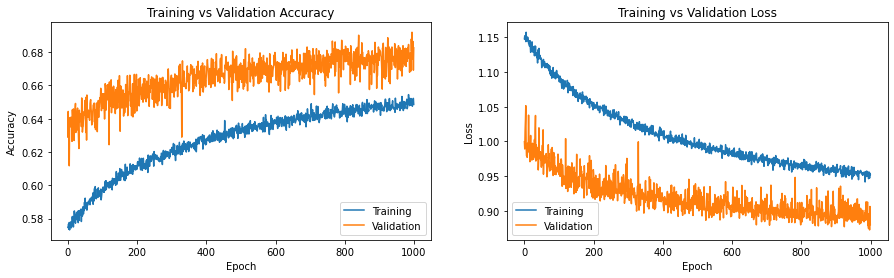

Evaluate on test data


2022-05-19 12:10:56.292588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 21ms/step - loss: 0.8787 - accuracy: 0.6760
test_loss, test_acc:  0.8787 67.6039


In [21]:
history_mdl16_4 = mdl16_4.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 1000,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_4)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_4.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

In [ ]:
mdl16_4.save('../../../project_data/mdl16_4.h5')

# Another 300 epochs to see if it could get above 68%

In [23]:
# creating generators for image augmentation
train_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'   
)

train_gen.fit(X_train)
train_batch = 1024
train_gen = train_gen.flow(X_train, y_train, batch_size=train_batch)

valid_gen = ImageDataGenerator()
valid_batch = 128
valid_gen = valid_gen.flow(X_valid, y_valid, batch_size=valid_batch)

#checkpoint to save best weights
checkpoint_path = "../../../project_data/train_ckpt/cp_mdl16_5.ckpt"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_accuracy',
                                                save_weights_only=True,
                                                mode='max',
                                                save_best_only=True,
                                                verbose=1)

#define callbacks
callbacks = [checkpoint]

Epoch 1/300


2022-05-19 12:17:16.764045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/30 [==============================] - ETA: 0s - loss: 0.9761 - accuracy: 0.6402

2022-05-19 12:17:28.913883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.68516, saving model to ../../../project_data/train_ckpt/cp_mdl16_5.ckpt
30/30 [==============================] - 13s 383ms/step - loss: 0.9761 - accuracy: 0.6402 - val_loss: 0.8880 - val_accuracy: 0.6852
Epoch 2/300
31/30 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.6463
Epoch 2: val_accuracy did not improve from 0.68516
30/30 [==============================] - 11s 368ms/step - loss: 0.9672 - accuracy: 0.6463 - val_loss: 0.8936 - val_accuracy: 0.6765
Epoch 3/300
31/30 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.6417
Epoch 3: val_accuracy improved from 0.68516 to 0.68718, saving model to ../../../project_data/train_ckpt/cp_mdl16_5.ckpt
30/30 [==============================] - 11s 367ms/step - loss: 0.9718 - accuracy: 0.6417 - val_loss: 0.8820 - val_accuracy: 0.6872
Epoch 4/300
31/30 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.6448
Epoch 4: val_accuracy did no

Epoch 30/300
31/30 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.6457
Epoch 30: val_accuracy did not improve from 0.68870
30/30 [==============================] - 16s 515ms/step - loss: 0.9631 - accuracy: 0.6457 - val_loss: 0.9108 - val_accuracy: 0.6677
Epoch 31/300
31/30 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.6461
Epoch 31: val_accuracy did not improve from 0.68870
30/30 [==============================] - 16s 528ms/step - loss: 0.9603 - accuracy: 0.6461 - val_loss: 0.8858 - val_accuracy: 0.6824
Epoch 32/300
31/30 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.6441
Epoch 32: val_accuracy did not improve from 0.68870
30/30 [==============================] - 17s 535ms/step - loss: 0.9678 - accuracy: 0.6441 - val_loss: 0.9166 - val_accuracy: 0.6684
Epoch 33/300
31/30 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.6483
Epoch 33: val_accuracy did not improve from 0.68870
30/30 [=====

31/30 [==============================] - ETA: 0s - loss: 0.9629 - accuracy: 0.6435
Epoch 59: val_accuracy did not improve from 0.68870
30/30 [==============================] - 23s 745ms/step - loss: 0.9629 - accuracy: 0.6435 - val_loss: 0.9206 - val_accuracy: 0.6674
Epoch 60/300
31/30 [==============================] - ETA: 0s - loss: 0.9560 - accuracy: 0.6490
Epoch 60: val_accuracy did not improve from 0.68870
30/30 [==============================] - 23s 743ms/step - loss: 0.9560 - accuracy: 0.6490 - val_loss: 0.9068 - val_accuracy: 0.6727
Epoch 61/300
31/30 [==============================] - ETA: 0s - loss: 0.9595 - accuracy: 0.6488
Epoch 61: val_accuracy did not improve from 0.68870
30/30 [==============================] - 23s 764ms/step - loss: 0.9595 - accuracy: 0.6488 - val_loss: 0.8840 - val_accuracy: 0.6841
Epoch 62/300
31/30 [==============================] - ETA: 0s - loss: 0.9540 - accuracy: 0.6492
Epoch 62: val_accuracy did not improve from 0.68870
30/30 [==================

31/30 [==============================] - ETA: 0s - loss: 0.9612 - accuracy: 0.6485
Epoch 88: val_accuracy did not improve from 0.68870
30/30 [==============================] - 19s 600ms/step - loss: 0.9612 - accuracy: 0.6485 - val_loss: 0.8868 - val_accuracy: 0.6826
Epoch 89/300
31/30 [==============================] - ETA: 0s - loss: 0.9631 - accuracy: 0.6465
Epoch 89: val_accuracy did not improve from 0.68870
30/30 [==============================] - 19s 606ms/step - loss: 0.9631 - accuracy: 0.6465 - val_loss: 0.9139 - val_accuracy: 0.6727
Epoch 90/300
31/30 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.6498
Epoch 90: val_accuracy did not improve from 0.68870
30/30 [==============================] - 19s 601ms/step - loss: 0.9543 - accuracy: 0.6498 - val_loss: 0.8809 - val_accuracy: 0.6796
Epoch 91/300
31/30 [==============================] - ETA: 0s - loss: 0.9505 - accuracy: 0.6538
Epoch 91: val_accuracy did not improve from 0.68870
30/30 [==================

Epoch 117/300
31/30 [==============================] - ETA: 0s - loss: 0.9639 - accuracy: 0.6463
Epoch 117: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 568ms/step - loss: 0.9639 - accuracy: 0.6463 - val_loss: 0.9195 - val_accuracy: 0.6707
Epoch 118/300
31/30 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.6457
Epoch 118: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 572ms/step - loss: 0.9589 - accuracy: 0.6457 - val_loss: 0.8791 - val_accuracy: 0.6811
Epoch 119/300
31/30 [==============================] - ETA: 0s - loss: 0.9530 - accuracy: 0.6486
Epoch 119: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 573ms/step - loss: 0.9530 - accuracy: 0.6486 - val_loss: 0.8900 - val_accuracy: 0.6836
Epoch 120/300
31/30 [==============================] - ETA: 0s - loss: 0.9569 - accuracy: 0.6481
Epoch 120: val_accuracy did not improve from 0.69022
30/3

31/30 [==============================] - ETA: 0s - loss: 0.9543 - accuracy: 0.6499
Epoch 146: val_accuracy did not improve from 0.69022
30/30 [==============================] - 18s 597ms/step - loss: 0.9543 - accuracy: 0.6499 - val_loss: 0.9055 - val_accuracy: 0.6722
Epoch 147/300
31/30 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.6503
Epoch 147: val_accuracy did not improve from 0.69022
30/30 [==============================] - 19s 610ms/step - loss: 0.9519 - accuracy: 0.6503 - val_loss: 0.8900 - val_accuracy: 0.6806
Epoch 148/300
31/30 [==============================] - ETA: 0s - loss: 0.9515 - accuracy: 0.6517
Epoch 148: val_accuracy did not improve from 0.69022
30/30 [==============================] - 21s 680ms/step - loss: 0.9515 - accuracy: 0.6517 - val_loss: 0.9012 - val_accuracy: 0.6720
Epoch 149/300
31/30 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.6526
Epoch 149: val_accuracy did not improve from 0.69022
30/30 [===========

31/30 [==============================] - ETA: 0s - loss: 0.9565 - accuracy: 0.6505
Epoch 175: val_accuracy did not improve from 0.69022
30/30 [==============================] - 20s 632ms/step - loss: 0.9565 - accuracy: 0.6505 - val_loss: 0.9011 - val_accuracy: 0.6786
Epoch 176/300
31/30 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.6476
Epoch 176: val_accuracy did not improve from 0.69022
30/30 [==============================] - 20s 651ms/step - loss: 0.9559 - accuracy: 0.6476 - val_loss: 0.9138 - val_accuracy: 0.6735
Epoch 177/300
31/30 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.6468
Epoch 177: val_accuracy did not improve from 0.69022
30/30 [==============================] - 21s 663ms/step - loss: 0.9567 - accuracy: 0.6468 - val_loss: 0.9098 - val_accuracy: 0.6695
Epoch 178/300
31/30 [==============================] - ETA: 0s - loss: 0.9587 - accuracy: 0.6428
Epoch 178: val_accuracy did not improve from 0.69022
30/30 [===========

Epoch 204/300
31/30 [==============================] - ETA: 0s - loss: 0.9450 - accuracy: 0.6516
Epoch 204: val_accuracy did not improve from 0.69529
30/30 [==============================] - 21s 686ms/step - loss: 0.9450 - accuracy: 0.6516 - val_loss: 0.8894 - val_accuracy: 0.6831
Epoch 205/300
31/30 [==============================] - ETA: 0s - loss: 0.9501 - accuracy: 0.6514
Epoch 205: val_accuracy did not improve from 0.69529
30/30 [==============================] - 22s 726ms/step - loss: 0.9501 - accuracy: 0.6514 - val_loss: 0.8999 - val_accuracy: 0.6748
Epoch 206/300
31/30 [==============================] - ETA: 0s - loss: 0.9466 - accuracy: 0.6509
Epoch 206: val_accuracy did not improve from 0.69529
30/30 [==============================] - 21s 676ms/step - loss: 0.9466 - accuracy: 0.6509 - val_loss: 0.8844 - val_accuracy: 0.6783
Epoch 207/300
31/30 [==============================] - ETA: 0s - loss: 0.9494 - accuracy: 0.6501
Epoch 207: val_accuracy did not improve from 0.69529
30/3

31/30 [==============================] - ETA: 0s - loss: 0.9440 - accuracy: 0.6548
Epoch 233: val_accuracy did not improve from 0.69529
30/30 [==============================] - 21s 672ms/step - loss: 0.9440 - accuracy: 0.6548 - val_loss: 0.8762 - val_accuracy: 0.6877
Epoch 234/300
31/30 [==============================] - ETA: 0s - loss: 0.9525 - accuracy: 0.6544
Epoch 234: val_accuracy did not improve from 0.69529
30/30 [==============================] - 21s 693ms/step - loss: 0.9525 - accuracy: 0.6544 - val_loss: 0.8885 - val_accuracy: 0.6869
Epoch 235/300
31/30 [==============================] - ETA: 0s - loss: 0.9488 - accuracy: 0.6511
Epoch 235: val_accuracy did not improve from 0.69529
30/30 [==============================] - 20s 661ms/step - loss: 0.9488 - accuracy: 0.6511 - val_loss: 0.8945 - val_accuracy: 0.6781
Epoch 236/300
31/30 [==============================] - ETA: 0s - loss: 0.9475 - accuracy: 0.6528
Epoch 236: val_accuracy did not improve from 0.69529
30/30 [===========

31/30 [==============================] - ETA: 0s - loss: 0.9494 - accuracy: 0.6511
Epoch 262: val_accuracy did not improve from 0.69529
30/30 [==============================] - 20s 642ms/step - loss: 0.9494 - accuracy: 0.6511 - val_loss: 0.9331 - val_accuracy: 0.6601
Epoch 263/300
31/30 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.6501
Epoch 263: val_accuracy did not improve from 0.69529
30/30 [==============================] - 20s 656ms/step - loss: 0.9500 - accuracy: 0.6501 - val_loss: 0.8969 - val_accuracy: 0.6819
Epoch 264/300
31/30 [==============================] - ETA: 0s - loss: 0.9399 - accuracy: 0.6542
Epoch 264: val_accuracy did not improve from 0.69529
30/30 [==============================] - 20s 639ms/step - loss: 0.9399 - accuracy: 0.6542 - val_loss: 0.8938 - val_accuracy: 0.6720
Epoch 265/300
31/30 [==============================] - ETA: 0s - loss: 0.9481 - accuracy: 0.6536
Epoch 265: val_accuracy did not improve from 0.69529
30/30 [===========

31/30 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.6540
Epoch 291: val_accuracy did not improve from 0.69529
30/30 [==============================] - 21s 680ms/step - loss: 0.9500 - accuracy: 0.6540 - val_loss: 0.8939 - val_accuracy: 0.6740
Epoch 292/300
31/30 [==============================] - ETA: 0s - loss: 0.9475 - accuracy: 0.6508
Epoch 292: val_accuracy did not improve from 0.69529
30/30 [==============================] - 21s 683ms/step - loss: 0.9475 - accuracy: 0.6508 - val_loss: 0.8820 - val_accuracy: 0.6821
Epoch 293/300
31/30 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.6536
Epoch 293: val_accuracy did not improve from 0.69529
30/30 [==============================] - 20s 646ms/step - loss: 0.9442 - accuracy: 0.6536 - val_loss: 0.9025 - val_accuracy: 0.6768
Epoch 294/300
31/30 [==============================] - ETA: 0s - loss: 0.9486 - accuracy: 0.6538
Epoch 294: val_accuracy did not improve from 0.69529
30/30 [===========

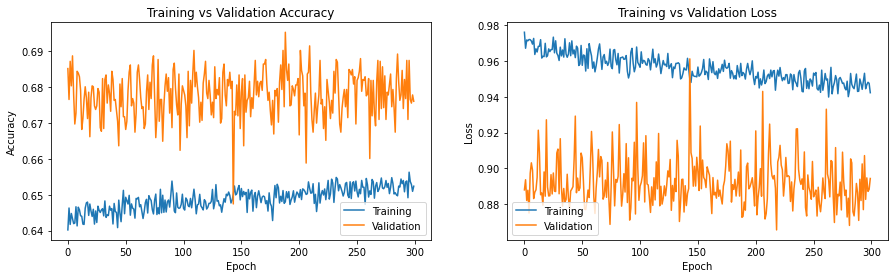

Evaluate on test data


2022-05-19 13:53:31.754105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 24ms/step - loss: 0.8949 - accuracy: 0.6720
test_loss, test_acc:  0.8949 67.1986


In [24]:
# load the model and run a summary
mdl16_5 = tf.keras.models.load_model('../../../project_data/mdl16_4.h5')

history_mdl16_5 = mdl16_5.fit(
      train_gen,
      validation_data = valid_gen,  
      epochs = 300,
      steps_per_epoch=len(X_train)/train_batch,
      validation_steps=len(X_valid)/valid_batch,
      verbose=1,
      callbacks=[callbacks])

plot_model_accuracy(history_mdl16_5)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_5.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_loss, test_acc = mdl16_5.evaluate(X_test, y_test, batch_size=128)
print('test_loss, test_acc: ',np.round(test_loss,4), np.round(test_acc*100.0,4))

Evaluate on test data
31/31 [==============================] - 1s 17ms/step - loss: 0.8949 - accuracy: 0.6720
test_loss, test_acc:  0.8949 67.1986


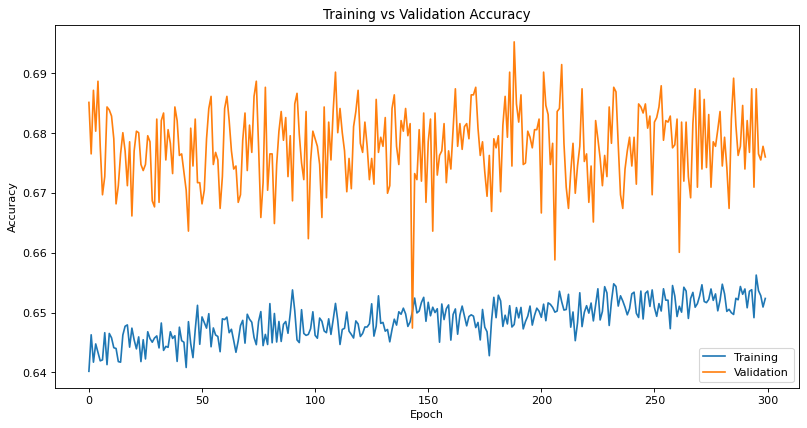

In [36]:
fitted_model = history_mdl16_5
plt.figure(figsize=(12, 6), dpi=80)

plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.show()